# The Reuters corpus

In [3]:
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.stem import PorterStemmer
import re
import nltk
from nltk.corpus import reuters
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt') # for tokenizing
nltk.download('stopwords')

def read_data_from_directory(directory_path):
    authors = os.listdir(directory_path)
    texts = []
    labels = []
    for author in authors:
        author_path = os.path.join(directory_path, author)
        if os.path.isdir(author_path):  # This prevents non-directory files from being processed
            for file_name in os.listdir(author_path):
                file_path = os.path.join(author_path, file_name)
                with open(file_path, 'r', encoding='utf-8') as f:
                    texts.append(f.read())
                    labels.append(author)
        else:
            print(f"Skipping non-directory file: {author_path}")
    return texts, labels


# Reading the training and test data
X_train_text, y_train_label = read_data_from_directory("/Users/xinyiliu/Desktop/MSBA/STA - 380 Introduction to Machine Learning/Part 2/STA380-master/data/ReutersC50/C50train")
X_test_text, y_test_label = read_data_from_directory("/Users/xinyiliu/Desktop/MSBA/STA - 380 Introduction to Machine Learning/Part 2/STA380-master/data/ReutersC50/C50test")

[nltk_data] Downloading package punkt to /Users/xinyiliu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xinyiliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Skipping non-directory file: /Users/xinyiliu/Desktop/MSBA/STA - 380 Introduction to Machine Learning/Part 2/STA380-master/data/ReutersC50/C50train/.DS_Store
Skipping non-directory file: /Users/xinyiliu/Desktop/MSBA/STA - 380 Introduction to Machine Learning/Part 2/STA380-master/data/ReutersC50/C50test/.DS_Store


In [4]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    doc = text.lower()
    doc = re.sub(r'[^a-z]+', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [5]:
X_train_text = [preprocess_text(text) for text in X_train_text]
X_test_text = [preprocess_text(text) for text in X_test_text]

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_label)
y_test = label_encoder.transform(y_test_label)

### Do a 80/20 split on the training set

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Perform 80/20 split on X_train_text and y_train_label
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


### Logistic regression

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
# Step 4: Perform Grid Search with Cross-Validation for Hyperparameter Tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2']  # Lasso or Ridge Regularization
}

logreg = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model from Grid Search
best_logreg_model = grid_search.best_estimator_

# Step 5: Make Predictions on Validation Set
y_val_pred = best_logreg_model.predict(X_val)

# Step 6: Evaluate Model Performance
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Validation Accuracy: 1.0000


### Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=5000, random_state=42, max_features = 'sqrt')

# Train the model on X_train1 and y_train1
rf_model.fit(X_train1, y_train1)

# Make predictions on the validation set
y_val_pred = rf_model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Random Forest Validation Accuracy: {accuracy:.4f}")


Random Forest Validation Accuracy: 0.7940


<Axes: xlabel='Feature'>

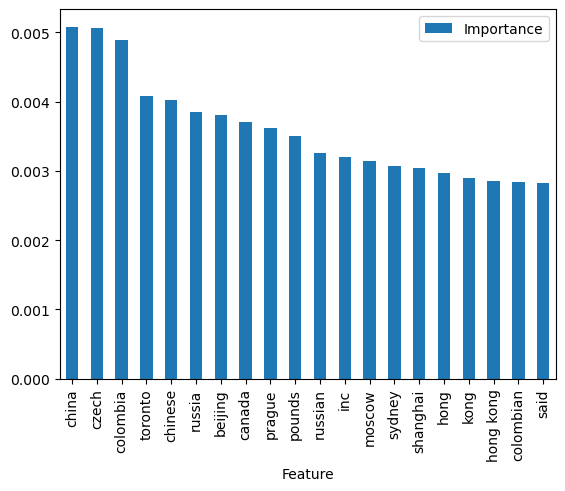

In [13]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd


feature_importances = rf_model.feature_importances_

# Get the feature names (these are the words from your TF-IDF or CountVectorizer)
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame with feature names and their corresponding importance scores
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance score in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
importance_df.head(20).set_index('Feature').plot(kind='bar')


### Out of sample Test - Without dropping unkown words

### - Logistic

In [16]:
# Predict on the out-of-sample test set
y_test_pred = best_logreg_model.predict(X_test)

# Evaluate performance on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

Test Set Accuracy: 0.6836


### - Random Forest

In [18]:
y_test_pred = rf_model.predict(X_test)

# Evaluate performance on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

Test Set Accuracy: 0.6484


### Dropping words

In [20]:
# Step 2: Create a vocabulary set from the training data
train_vocab = set(vectorizer.get_feature_names_out())

# Step 3: Function to replace unseen words in the test data with "<UNK>"
def replace_unseen_words(text, vocab):
    words = text.split()
    return ' '.join([word if word in vocab else "<UNK>" for word in words])

# Replace unseen words in the test data
X_test_text_drop = [replace_unseen_words(doc, train_vocab) for doc in X_test_text]

# Step 4: Transform the modified test data
X_test_drop = vectorizer.transform(X_test_text_drop)


### - Logistic

In [22]:
# Predict on the out-of-sample test set
y_test_pred_lg = best_logreg_model.predict(X_test_drop)

# Evaluate performance on the test set
test_accuracy = accuracy_score(y_test, y_test_pred_lg)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

Test Set Accuracy: 0.5852


### -Random Forest

In [24]:
# Predict on the out-of-sample test set
y_test_pred_rf = rf_model.predict(X_test_drop)

# Evaluate performance on the test set
test_accuracy = accuracy_score(y_test, y_test_pred_rf)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

Test Set Accuracy: 0.4588


Question:
1. Can we accurately classify authors based on their writing style?
2. What key features distinguish different authors? 
3. What is the impact of unseen words in the test set on model accuracy?

Approach:
1. Preprocessing and Feature Extraction:
The text data was preprocessed by tokenizing, removing stopwords, and stemming the words. Utilizing TF-IDF (Term Frequency-Inverse Document Frequency) as the feature extraction technique. This allowed us to quantify the importance of each word or phrase across the documents, with a maximum of 5000 features and a focus on unigrams and bigrams.
2. Predictive Modeling:
Logistic Regression: Using L1 and L2 regularization through GridSearchCV, the hyperparameters are tuned to maximize accuracy.
Random Forest: Random Forest Classifier with 5000 estimators and 'sqrt' for max_features to examine the feature importance.
3. Handling Unseen Words:
Replaced any unseen words in the test set with a placeholder "<UNK>", re-transformed the data, and compared the accuracy before and after handling unseen words.
4. Feature Importance:
Analyzed the most important features (words) for author classification using the Random Forest model. This provided insight into which words were most influential in distinguishing authors.

Results:
1. Model Accuracy:
Logistic Regression: The logistic regression model achieved a validation accuracy of 100% on the training set (X_train1, y_train1). However, when evaluated on the test set, the accuracy dropped to 68.36%. This suggests that while the model performed exceedingly well on the validation set, it struggled to generalize as effectively to unseen data.
Random Forest: The random forest model achieved a validation accuracy of 79.4%, which is lower than logistic regression but more consistent with the test set accuracy of 64.84%. This suggests that random forest, though less precise than logistic regression on the training set, was more stable when tested on new data.
2. Handling Unseen Words:
Without Handling Unseen Words: Logistic regression had a test accuracy of 68.36% and random forest had 64.84%.
After Handling Unseen Words: The performance decreased significantly when unseen words in the test set were replaced with "<UNK>". Logistic regression's accuracy dropped to 58.52%, and random forest’s accuracy dropped to 45.88%. This suggests that unseen words play a vital role in the accuracy of text classification and that removing them may strip essential context from the test data.
3. Feature Importance:
The random forest model’s feature importance analysis revealed that words related to specific locations such as "china," "toronto," and "colombia" were among the most important features for classifying authors. This indicates that geographical references could be key distinguishing factors between different authors, especially when they report on different regions or write about specific topics.

Conclusion:
1. Predictive Modeling: Logistic regression, with proper regularization, performed exceedingly well in the training set but showed signs of overfitting when applied to unseen data. Random forest, on the other hand, demonstrated more stability but slightly lower performance on both validation and test sets. This suggests that combining both models in an ensemble or applying advanced techniques such as boosting could potentially yield better results on classifying authors based on their writings. 
2. Impact of Unseen Words: The significant drop in performance after removing unseen words indicates that handling new words in the test set is a crucial challenge in text classification. This emphasizes the need for robust handling strategies, such as word embeddings, to capture the semantic meaning of previously unseen words.
3. Feature Importance: The analysis showed that geographic references play a significant role in distinguishing authors. This highlights the importance of domain-specific knowledge when interpreting text classification models, as certain authors may focus on specific regions or topics, leading to highly informative features.

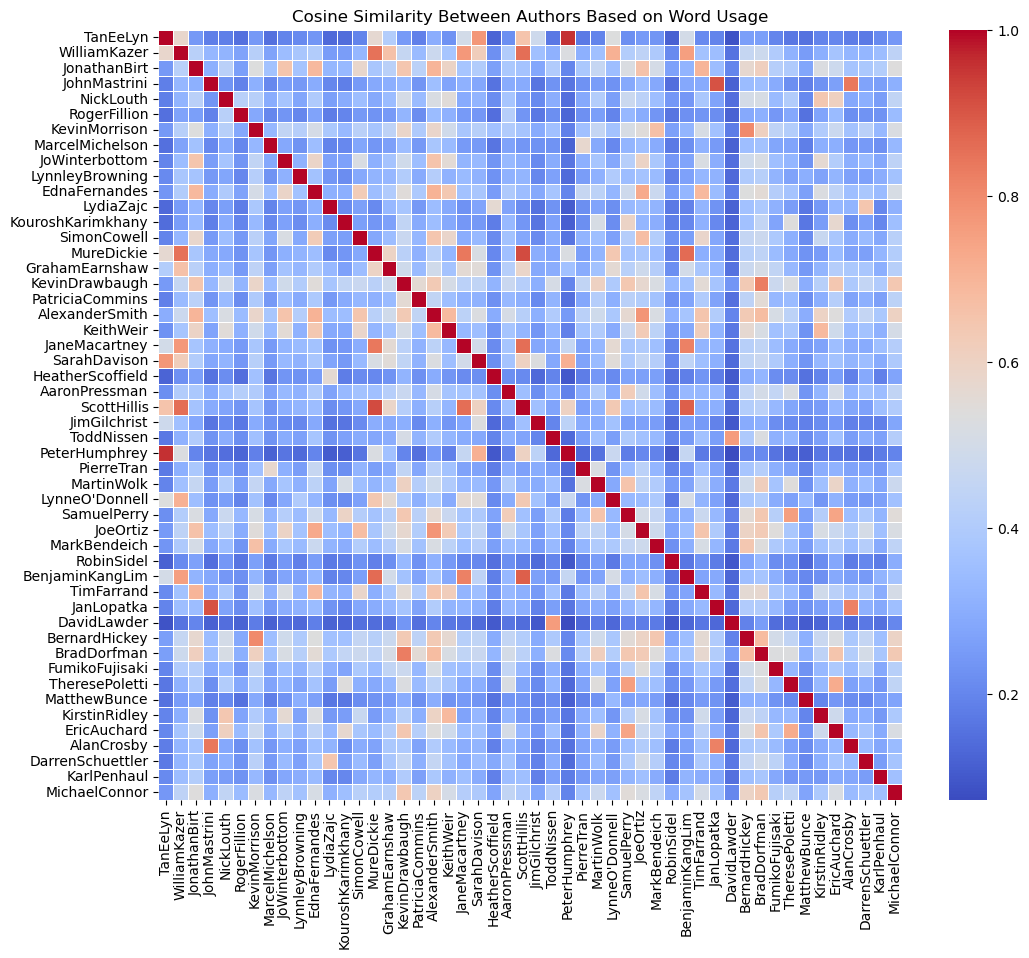

In [25]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Preprocess the textdefpreprocess_text(text):
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    doc = text.lower()
    doc = re.sub(r'[^a-z]+', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Step 2: Aggregate texts by author
author_texts_dict = {author: [] for author in set(y_train_label)}

for text, label in zip(X_train_text, y_train_label):
    author_texts_dict[label].append(preprocess_text(text))

# Combine texts for each author into a single string
aggregated_texts = {author: " ".join(texts) for author, texts in author_texts_dict.items()}

# Step 3: Convert aggregated texts into TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=2500)
author_tfidf = tfidf_vectorizer.fit_transform(aggregated_texts.values())

# Step 4: Calculate the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(author_tfidf)

# Step 5: Create a heatmap
authors = list(aggregated_texts.keys())
sim_df = pd.DataFrame(cosine_sim_matrix, index=authors, columns=authors)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(sim_df, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Cosine Similarity Between Authors Based on Word Usage")
plt.show()


In [26]:
import numpy as np

# Flatten the cosine similarity matrix to get all author pairs
similarity_pairs = []

# Iterate over the upper triangle of the similarity matrix (excluding the diagonal)
for i in range(len(authors)):
    for j in range(i + 1, len(authors)):
        similarity_pairs.append((authors[i], authors[j], cosine_sim_matrix[i, j]))

# Sort the pairs by similarity in descending order
sorted_pairs = sorted(similarity_pairs, key=lambda x: x[2], reverse=True)

# Get the top 10 most similar pairs
top_10_similar_pairs = sorted_pairs[:10]

# Display the results
print("Top 10 Most Similar Author Pairs:")
for pair in top_10_similar_pairs:
    print(f"Authors: {pair[0]} and {pair[1]}, Similarity Score: {pair[2]:.4f}")


Top 10 Most Similar Author Pairs:
Authors: TanEeLyn and PeterHumphrey, Similarity Score: 0.9579
Authors: MureDickie and ScottHillis, Similarity Score: 0.9200
Authors: JohnMastrini and JanLopatka, Similarity Score: 0.9079
Authors: ScottHillis and BenjaminKangLim, Similarity Score: 0.8875
Authors: MureDickie and BenjaminKangLim, Similarity Score: 0.8648
Authors: WilliamKazer and ScottHillis, Similarity Score: 0.8577
Authors: JaneMacartney and ScottHillis, Similarity Score: 0.8554
Authors: WilliamKazer and MureDickie, Similarity Score: 0.8485
Authors: JohnMastrini and AlanCrosby, Similarity Score: 0.8383
Authors: MureDickie and JaneMacartney, Similarity Score: 0.8374


Question:
Which authors in the Reuters C50 dataset have the most similar writing styles based on their word usage?

Approach:
Using TF-IDF vectorization, then aggregated each author's articles into a single document and computed the cosine similarity between all author pairs. The top 10 most similar author pairs were identified based on their similarity scores.

Results:
The analysis revealed that certain authors have highly similar writing styles. The most similar author pair was TanEeLyn and PeterHumphrey with a similarity score of 0.9579. Other notable pairs include MureDickie and ScottHillis (0.9200) and JohnMastrini and JanLopatka (0.9079). Multiple authors, such as MureDickie, appear in multiple top pairs, suggesting they share similar vocabulary with more than one other author.

Conclusion:
This analysis highlights that certain authors exhibit very similar writing styles, likely due to shared coverage areas or topics. This could provide insight into the thematic consistency or shared stylistic conventions across authors in the dataset.